In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#!kaggle datasets download -d ludovicocuoghi/twitter-sentiment-analysis-with-bert-vs-roberta
#https://www.kaggle.com/code/ludovicocuoghi/twitter-sentiment-analysis-with-bert-vs-roberta

403 - Forbidden - Permission 'datasets.get' was denied


In [ ]:
!pip install emoji


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 17.7 MB/s eta 0:00:00


In [ ]:
!pip install transformers

In [ ]:
#importing libraris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

#import data preprocessing librairs
import re,string
import emoji
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

#naive bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizer
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
from tensorflow import keras

#metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score


In [ ]:
#loading dataset

df = pd.read_csv('/content/Corona_NLP_train.csv', encoding = 'ISO-8859-1')
df_test = pd.read_csv('/content/Corona_NLP_test.csv')

In [ ]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [ ]:
df['TweetAt'] = pd.to_datetime(df['TweetAt'])

<ipython-input-8-45b9b0fe6852>:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['TweetAt'] = pd.to_datetime(df['TweetAt'])


In [ ]:
df.drop_duplicates(subset = 'OriginalTweet',inplace = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       41157 non-null  int64         
 1   ScreenName     41157 non-null  int64         
 2   Location       32567 non-null  object        
 3   TweetAt        41157 non-null  datetime64[ns]
 4   OriginalTweet  41157 non-null  object        
 5   Sentiment      41157 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.9+ MB


In [ ]:
# cleaning

In [ ]:
df = df[['OriginalTweet','Sentiment']]

In [ ]:
df_test = df_test[['OriginalTweet','Sentiment']]

In [ ]:
#clean the emoji
def strip_emoji(text):
  return emoji.replace_emoji(text, replace='')

#remove punctuations,links, and new line characters
def strip_all_entities(text):
  text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower()
  text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
  text = re.sub(r'[^\x00-\x7f]',r'', text)
  banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
  table = str.maketrans('', '', banned_list)
  text = text.translate(table)
  return text

#clean the hashtags
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#filter the special characters
def filter_chars(a):
  sent = []
  for word in a.split(' '):
    if ('$' in word) | ('&' in word):
      sent.append('')
    else:
      sent.append(word)
  return ' '.join(sent)

#remove multiple spaces
def remove_mult_spaces(text):
  return re.sub("\s\s+" , " ", text)



In [ ]:
texts_new = []
for t in df.OriginalTweet:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [ ]:
texts_new_test = []
for t in df_test.OriginalTweet:
    texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))


In [ ]:
df['text_clean'] = texts_new
df_test['text_clean'] = texts_new_test

In [ ]:
df['text_clean'].head()

,text_clean
0,and and
1,advice talk to your neighbours family to excha...
2,coronavirus australia woolworths to give elder...
3,my food stock is not the only one which is emp...
4,me ready to go at supermarket during the covid...


In [ ]:
df_test['text_clean'].head()

,text_clean
0,trending new yorkers encounter empty supermark...
1,when i couldnt find hand sanitizer at fred mey...
2,find out how you can protect yourself and love...
3,panic buying hits newyork city as anxious shop...
4,toiletpaper dunnypaper coronavirus coronavirus...


In [ ]:
df['text_clean'][1:8].values

array(['advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order',
       'coronavirus australia woolworths to give elderly disabled dedicated shopping hours amid covid19 outbreak',
       'my food stock is not the only one which is empty please dont panic there will be enough food for everyone if you do not take more than you need stay calm stay safe covid19france covid19 covid19 coronavirus confinement confinementotal confinementgeneral',
       'me ready to go at supermarket during the covid19 outbreak not because im paranoid but because my food stock is litteraly empty the coronavirus is a serious thing but please dont panic it causes shortage coronavirusfrance restezchezvous stayathome confinement',
       'as news of the regions first confirmed covid19 case came out of sullivan county last week people 

In [ ]:
text_len = []
for text in df.text_clean:
  tweet_len = len(text.split())
  text_len.append(tweet_len)

In [ ]:
df['text_len'] = text_len

In [ ]:
text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

In [ ]:
df_test['text_len'] = text_len_test

<ipython-input-25-6f9c3b55e95c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')


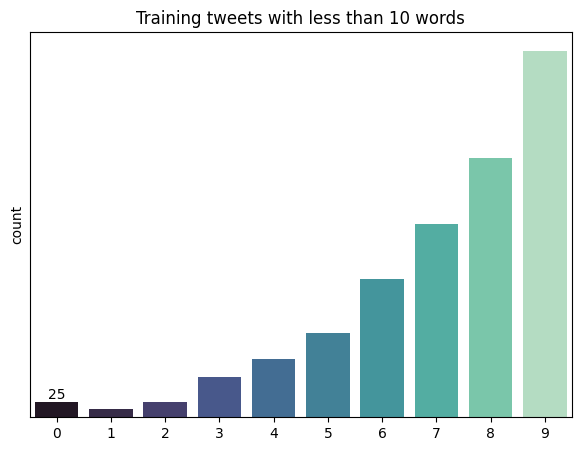

In [ ]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

<ipython-input-26-7979c0899f38>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='text_len', data=df_test[df_test['text_len']<10], palette='mako')


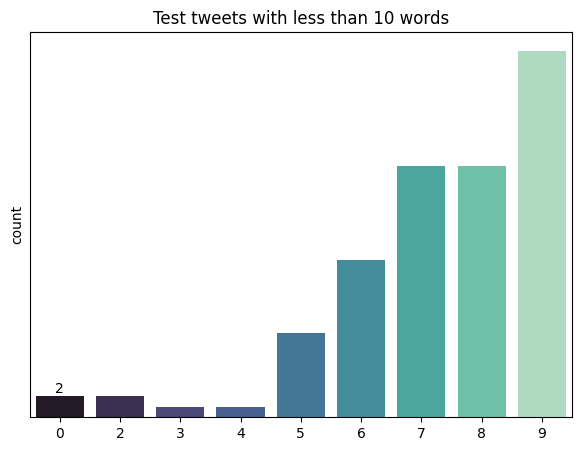

In [ ]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_test[df_test['text_len']<10], palette='mako')
plt.title('Test tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [ ]:
print("DF shape:",df.shape)
print("DF_TEST shape:",df_test.shape)

DF shape: (41157, 4)
DF_TEST shape: (3798, 4)


In [ ]:
df = df[df['text_len'] > 4]

In [ ]:
df_test = df_test[df_test['text_len'] > 4]

In [ ]:
print("DF shape:",df.shape)
print("DF_TEST shape:",df_test.shape)

DF shape: (40935, 4)
DF_TEST shape: (3792, 4)


In [ ]:
#import the BERT tokenizer

In [ ]:
from transformers import BertTokenizerFast

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
token_lens = []

for txt in df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)

In [ ]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")


MAX TOKENIZED SENTENCE LENGTH: 100


In [ ]:
token_lens = []

for i,txt in enumerate(df['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 1622, TEXT: zsah policie proti spekulantm s roukami na mj popud hejtman steckho kraje ve spoluprci s podle krizovho zkona zajistil tm 700 tisrouek od firmy kter je mla dodat na zdravotnkm ale na posledn chvli se snaila navyovat cenu spolutozvladneme
INDEX: 13623, TEXT: hoy aplaudo a mi segunda familia aplaudoanuestrosheroes aquellos con los que he compartido tantas noches de trabajo y tanta alegra s que como siempre dan todo por el bien de su comunidad presidente por ellos tambin cuarentenanacionalya cuidemosalosquecuidan
INDEX: 16548, TEXT: bir mddettir spermarketlerin lojistik hizmeti avusturya ordusu desteiyle yaplyor dn corona tedavisi iin 22 milyon luk bir aratrma gelitirme btesi aklad hkmet geen hafta da 35 milyon luk 2 yardm paketi aklanmt viyanadan haberler bu kadar
INDEX: 36953, TEXT: 11 nisan cumartesi itibariyle bbnin tm hizmetleri sokaa kma serbestisi olanlar iin devam edecek halk ekmek ve hamidiye su 100 retime geti bb tm stanbulun gda ihtiyacna yetecek kapasitededi

In [ ]:
df['token_lens'] = token_lens

In [ ]:
df = df.sort_values(by='token_lens', ascending=False)
df.head(20)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
1638,ZÃ¡sah policie proti spekulant?m s rouÂkami. ...,Neutral,zsah policie proti spekulantm s roukami na mj ...,39,100
37156,11 Nisan Cumartesi itibariyle ?BBÂnin tÃ¼m hi...,Neutral,11 nisan cumartesi itibariyle bbnin tm hizmetl...,39,98
16632,Bir mÃ¼ddettir sÃ¼permarketlerin lojistik hizm...,Neutral,bir mddettir spermarketlerin lojistik hizmeti ...,36,92
13691,Hoy aplaudo a mi segunda familia #AplaudoANues...,Neutral,hoy aplaudo a mi segunda familia aplaudoanuest...,38,84
28899,Kindly contact Us bamy global merchandise for ...,Positive,kindly contact us bamy global merchandise for ...,37,80
14593,"Na, wer war denn da am Werk? Gestern Nachmitta...",Extremely Negative,na wer war denn da am werk gestern nachmittag ...,37,80
27005,Supermercados Econo confirman que un empleado ...,Neutral,supermercados econo confirman que un empleado ...,39,80
11213,Keine WertgegenstÃ¤nde im Fahrzeug lassen! - D...,Negative,keine wertgegenstnde im fahrzeug lassen diesen...,33,79
4844,Impct of #coronavirus i hve sen hw civilizd pp...,Extremely Negative,impct of coronavirus i hve sen hw civilizd ppl...,48,79
18913,#CroozefmNews \r\r\nPresident Museveni has ord...,Extremely Negative,croozefmnews president museveni has ordered th...,35,79


In [ ]:
df = df.iloc[12:]
df.head()

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
8730,?Bitte anschauen! (1/2)\r\r\n\r\r\nEmotionaler...,Negative,bitte anschauen 12 emotionaler aufruf von geha...,36,77
12389,"Okay, so I just checked the drug prices for #P...",Positive,okay so i just checked the drug prices for pla...,35,77
14582,hiked prices in the face of the Covid-19 crise...,Negative,hiked prices in the face of the covid19 crises...,47,77
1697,I work at a grocery store.\r\r\nWe wont get an...,Positive,i work at a grocery store we wont get any toil...,37,77
36305,Sterile disposable anti bacterial wet wipes an...,Negative,sterile disposable anti bacterial wet wipes an...,31,76


In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
token_lens_test = []

for txt in df_test['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))

max_len=np.max(token_lens_test)

In [ ]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 96


In [ ]:
token_lens_test = []

for i,txt in enumerate(df_test['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 286, TEXT: so hard to decide as much as i want to hodl my 2 ccdcv4 token our place is declared to lock down due to covid19 i will use this to buy some food to stock txnid093bd1db0c0d3a62af15883138a5f57d4cef35ae14e31e602b74489dd2524c7f my b
INDEX: 345, TEXT: informoval jsem zstupce vech obchodnch etzc o aktulnch opatench vldy etzce jsou zsobovny na 95 take nen dvod panikait zsoby potravin fakt nedojdou nen opravdu dvod dnes obsadit a vykoupit supermarkety
INDEX: 2380, TEXT: ahora seguid llorando por el papel higinico que no he comprado porque an tengo seguid creando histeria y preocupacin poniendo fotos de gente en pnico y estanteras vacas que yo seguir yendo a comercios responsables de barrio donde nos cuidan hoy y siempre gracias


In [ ]:
df_test['token_lens'] = token_lens_test

In [ ]:
df_test = df_test.sort_values(by='token_lens', ascending=False)
df_test.head(10)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
286,@Rhett800cc So hard to decide??. As much as I ...,Negative,so hard to decide as much as i want to hodl my...,38,96
2383,Ahora seguid llorando por el papel higiénico (...,Negative,ahora seguid llorando por el papel higinico qu...,44,94
345,Informoval jsem zástupce vech obchodních ?et?...,Neutral,informoval jsem zstupce vech obchodnch etzc o ...,31,86
1485,DTF-Dont Touch Face\r\r\nDWBH-Do Wash Both Ha...,Extremely Negative,dtfdont touch face dwbhdo wash both hands gtfo...,42,77
1209,Im in the DC/Maryland/Virginia (DMV) area &am...,Positive,im in the dcmarylandvirginia dmv area amphave ...,45,74
3505,Stop misusing ur privilege amp grow up Some1 c...,Positive,stop misusing ur privilege amp grow up some1 c...,57,73
1789,"For those that are cashlong, patient,calm&amp;...",Extremely Positive,for those that are cashlong patientcalmamphave...,44,71
855,"Lidl is total chaos, queues as long as the ais...",Extremely Negative,lidl is total chaos queues as long as the aisl...,62,70
2740,COVID-19: Your government will save ITSELF not...,Positive,covid19 your government will save itself not y...,43,70
2997,Stop #frenzybuying. You don't need most of wha...,Extremely Negative,stop frenzybuying you dont need most of what y...,38,70


In [ ]:
df_test = df_test.iloc[5:]
df_test.head(3)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
3505,Stop misusing ur privilege amp grow up Some1 c...,Positive,stop misusing ur privilege amp grow up some1 c...,57,73
1789,"For those that are cashlong, patient,calm&amp;...",Extremely Positive,for those that are cashlong patientcalmamphave...,44,71
855,"Lidl is total chaos, queues as long as the ais...",Extremely Negative,lidl is total chaos queues as long as the aisl...,62,70


In [ ]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

In [ ]:
#sentiment column analysis
df['Sentiment'].value_counts()

,count
Sentiment,
Positive,11381
Negative,9889
Neutral,7560
Extremely Positive,6618
Extremely Negative,5475


In [ ]:
df['Sentiment'] = df['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [ ]:
df_test['Sentiment'] = df_test['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [ ]:
df['Sentiment'].value_counts()

,count
Sentiment,
2,17999
0,15364
1,7560


In [ ]:
#class balancing by RandomOverSampler


In [ ]:
ros = RandomOverSampler()
train_x,train_y =ros.fit_resample(np.array(df['text_clean']).reshape(-1,1),np.array(df['Sentiment']).reshape(-1,1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Sentiment']);

In [ ]:
train_os['Sentiment'].value_counts()

,count
Sentiment,
2,17999
1,17999
0,17999


In [ ]:
X = train_os['text_clean'].values
y = train_os['Sentiment'].values

In [ ]:
seed=42

In [ ]:
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.1,stratify =y,random_state=seed)

In [ ]:
X_test = df_test['text_clean'].values
y_test = df_test['Sentiment'].values

In [ ]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [ ]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [ ]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 48597
VALIDATION DATA: 5400
TESTING DATA: 3787


In [ ]:
#Naive bayes model

In [ ]:
clf = CountVectorizer()
X_train_cv = clf.fit_transform(X_train)
X_test_cv = clf.fit_transform(X_test)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer # Import the necessary class

In [ ]:
clf = CountVectorizer()
X_train_cv = clf.fit_transform(X_train)
# Only transform the test data using the vocabulary learned from the training data
X_test_cv = clf.transform(X_test)

tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [ ]:
nb_clf = MultinomialNB()

In [ ]:
nb_clf.fit(X_train_tf,y_train_le)

MultinomialNB()

In [ ]:
nb_pred = nb_clf.predict(X_test_tf)

In [ ]:
print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_le,nb_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.71      0.78      0.75      1629
     Neutral       0.59      0.44      0.50       614
    Positive       0.74      0.73      0.73      1544

    accuracy                           0.71      3787
   macro avg       0.68      0.65      0.66      3787
weighted avg       0.70      0.71      0.70      3787



In [ ]:
#BERT sentiment analysis

In [ ]:
MAX_LEN = 128

In [ ]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
def create_model(bert_model, max_len=MAX_LEN):

    ##params###
    # Use learning_rate_schedule instead of decay
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-5,
        decay_steps=1000,  # Adjust decay_steps as needed
        decay_rate=0.9  # Adjust decay_rate as needed
    )
    opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')

    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')

    embeddings = bert_model([input_ids,attention_masks])[1]

    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)

    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)

    model.compile(opt, loss=loss, metrics=accuracy)


    return model

In [ ]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_2[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                             

In [ ]:
history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=32)

Epoch 1/4
1519/1519 [==============================] - 1311s 832ms/step - loss: 0.5494 - categorical_accuracy: 0.7835 - val_loss: 0.3603 - val_categorical_accuracy: 0.8724
Epoch 2/4
1519/1519 [==============================] - 1267s 834ms/step - loss: 0.2911 - categorical_accuracy: 0.8975 - val_loss: 0.2804 - val_categorical_accuracy: 0.9015
Epoch 3/4
1519/1519 [==============================] - 1265s 833ms/step - loss: 0.1988 - categorical_accuracy: 0.9310 - val_loss: 0.2410 - val_categorical_accuracy: 0.9196
Epoch 4/4
1519/1519 [==============================] - 1264s 832ms/step - loss: 0.1440 - categorical_accuracy: 0.9513 - val_loss: 0.2251 - val_categorical_accuracy: 0.9328


In [ ]:
result_bert = model.predict([test_input_ids,test_attention_masks])

119/119 [==============================] - 38s 283ms/step


In [ ]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

In [ ]:
# Step 1: Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
# Function for real-time prediction
def predict_sentiment(tweet):
    # Tokenize the input tweet
    input_ids, attention_masks = tokenize([tweet], MAX_LEN)

    # Make prediction using the trained model
    prediction = model.predict([input_ids, attention_masks])

    # Convert prediction to sentiment class (0, 1, 2)
    sentiment_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    predicted_class = np.argmax(prediction, axis=1)[0]

    return sentiment_map[predicted_class]

In [ ]:
# Step 2: Test with real-time input
tweet = input("Enter a tweet for sentiment prediction: ")
predicted_sentiment = predict_sentiment(tweet)
print(f"Predicted Sentiment: {predicted_sentiment}")

Enter a tweet for sentiment prediction: I love this new product its amazing 
1/1 [==============================] - 0s 148ms/step
Predicted Sentiment: Positive


In [ ]:
#BERT CLASSIFICATION REPORT

In [ ]:

print('Classification Report for BERT:\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

Classification Report for BERT:
               precision    recall  f1-score   support

    Negative       0.90      0.90      0.90      1629
     Neutral       0.78      0.80      0.79       614
    Positive       0.92      0.90      0.91      1544

   micro avg       0.89      0.89      0.89      3787
   macro avg       0.87      0.87      0.87      3787
weighted avg       0.89      0.89      0.89      3787
 samples avg       0.89      0.89      0.89      3787



In [ ]:
#model.save('bert_model.h5')

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#model.save('bert_models.keras')

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [ ]:
#tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
#tokenizer.save_pretrained('bert_tokenizer')

('bert_tokenizer/tokenizer_config.json',
 'bert_tokenizer/special_tokens_map.json',
 'bert_tokenizer/vocab.txt',
 'bert_tokenizer/added_tokens.json',
 'bert_tokenizer/tokenizer.json')

In [ ]:
import joblib

# Save the Naive Bayes model and the vectorizer
joblib.dump(clf, 'naive_bayes_model.pkl')
joblib.dump(tf_transformer, 'tfidf_transformer.pkl')


['tfidf_transformer.pkl']

In [ ]:
# Save the trained Naive Bayes model
joblib.dump(nb_clf, 'Naive_bayes_model.pkl')

['Naive_bayes_model.pkl']

In [ ]:
joblib.dump(clf, 'count_vectorizer.pkl')

['count_vectorizer.pkl']

In [ ]:
# Save the Keras model using the standard save method
model.save("BERT_MODEL")

# Save the tokenizer using save_pretrained, as it's a Hugging Face tokenizer
tokenizer.save_pretrained("BERT_TOKENIZER")

('BERT_TOKENIZER/tokenizer_config.json',
 'BERT_TOKENIZER/special_tokens_map.json',
 'BERT_TOKENIZER/vocab.txt',
 'BERT_TOKENIZER/added_tokens.json',
 'BERT_TOKENIZER/tokenizer.json')

In [ ]:
# Load the model and transformer
clf = joblib.load('naive_bayes_model.pkl')
tf_transformer = joblib.load('tfidf_transformer.pkl')


In [ ]:
# Load the saved model and transformers
clf = joblib.load('count_vectorizer.pkl')  # Load CountVectorizer
tf_transformer = joblib.load('tfidf_transformer.pkl')  # Load TfidfTransformer
nb_clf = joblib.load('Naive_bayes_model.pkl')  # Load Naive Bayes model

In [ ]:
def predict_sentiment(tweet):
    # Clean the tweet text (you can customize this part)
    tweet_cleaned = remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(tweet)))))

    # Transform the tweet text to match the format of training data
    tweet_cv = clf.transform([tweet_cleaned])  # Transform using the CountVectorizer
    tweet_tf = tf_transformer.transform(tweet_cv)  # Transform using the TfidfTransformer

    # Predict the sentiment using the Naive Bayes model
    prediction = nb_clf.predict(tweet_tf)

    # You can convert the prediction back to the original sentiment labels
    sentiment_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return sentiment_map[prediction[0]]


In [ ]:
# Example tweet
tweet = "I love this new product! It's amazing."

# Predict sentiment
print(predict_sentiment(tweet))  # Output will be "Positive" or other sentiments depending on your training


Positive


In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import gradio as gr
import tensorflow as tf
import numpy as np
from transformers import TFBertModel, BertTokenizer

In [ ]:
iface = gr.Interface(
    fn=predict_sentiment,                # The prediction function
    inputs=gr.Textbox(label="Enter a Tweet"),   # Textbox for user input
    outputs=gr.Textbox(label="Predicted Sentiment"),  # Textbox for displaying result
    live=True                              # Updates the prediction live as the user types
)



In [ ]:

# Step 4: Launch the Gradio Interface
iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ac3bed604b6d87a7dc.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# Enhanced Gradio Interface
iface = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(
        label="Enter a Tweet",
        placeholder="Type your tweet here...",
        lines=3,
        max_lines=5
    ),
    outputs=gr.Textbox(
        label="Predicted Sentiment"
    ),
    title="Real-Time Tweet Sentiment Analyzer",
    description="This tool uses a BERT model to analyze the sentiment of a given tweet in real time. Enter a tweet below and get the predicted sentiment (Negative, Neutral, or Positive).",
    examples=[
        "I am so happy with the new product update!",
        "This is the worst experience I have had.",
        "The weather today is just fine.",
        "Looking forward to the event tomorrow."
    ],
    theme="default",
    live=False  # You can set this to True if you want the predictions to update as the user types.
)

# Launch the interface
iface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5eb0954fadfcad9b2c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# Enhanced Gradio Interface with custom background color
iface = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(
        label="Enter a Tweet",
        placeholder="Type your tweet here...",
        lines=2
    ),
    outputs=gr.Textbox(label="Predicted Sentiment"),
    title="Real-Time Sentiment Analysis",
    description="Enter a tweet to predict its sentiment as Negative, Neutral, or Positive.",
    css=".gradio-container {background-color: #f0f8ff;}",  # Custom background color (Alice Blue)
)

# Launch the interface
iface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://209f38f071f39b277a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# Enhanced Gradio Interface with custom background color and additional details
iface = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(
        label="Enter a Tweet",
        placeholder="Type your tweet here...",
        lines=2
    ),
    outputs=gr.Textbox(label="Predicted Sentiment"),
    title="Real-Time Sentiment Analysis",
    description=(
        "This interface uses a fine-tuned BERT model to predict the sentiment "
        "of tweets as Negative, Neutral, or Positive. The objective is to help "
        "understand public opinions and reactions in real time. This model has "
        "been trained using state-of-the-art NLP techniques to ensure accuracy and efficiency."
    ),
    css="body { background-color: #E6E6FA; }",
    theme="default"  # Optional: You can also set a Gradio theme here
)

iface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9ad593867efa88eaf3.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
with gr.Blocks(css="body { background-color: black; color: #E6E6FA; }") as iface:
    gr.Markdown("""
    ## Real-Time Sentiment Analysis

    This interface uses a fine-tuned BERT model to predict the sentiment of tweets as Negative, Neutral, or Positive.
    The objective is to help understand public opinions and reactions in real time. This model has been trained using
    state-of-the-art NLP techniques to ensure accuracy and efficiency.

    ### Project Objective
    Leveraging the power of BERT (Bidirectional Encoder Representations from Transformers) for real-time sentiment analysis on tweets. By using a pre-trained BERT model fine-tuned on a labeled dataset, we achieve high accuracy in classifying sentiments into three categories: Negative, Neutral, and Positive.

    ### Model Overview
    - **Model**: Fine-tuned BERT (bert-base-uncased)
    - **Training**: The model has been trained on a dataset with categorical crossentropy as the loss function, and uses an exponential decay learning rate schedule.
    - **Purpose**: Assist in understanding public sentiment efficiently for real-time applications.
    """)

    input_text = gr.Textbox(
        label="Enter a Tweet",
        placeholder="Type your tweet here...",
        lines=2
    )
    output_text = gr.Textbox(label="Predicted Sentiment")

    gr.Interface(
        fn=predict_sentiment,
        inputs=input_text,
        outputs=output_text,
    ).launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a6d748e65f77da6d5b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
